<a href="https://colab.research.google.com/github/saketkc/pySCTransform/blob/master/notebooks/pbmc3k_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy leidenalg
!pip install git+https://github.com/saketkc/pySCTransform.git@feat/fix_poisson

     |████████████████████████████████| 1.4MB 27.0MB/s 
     |████████████████████████████████| 3.2MB 34.1MB/s 
  Cloning https://github.com/saketkc/pySCTransform.git (to revision feat/fix_poisson) to /tmp/pip-req-build-ucgjs4n6
  Running command git clone -q https://github.com/saketkc/pySCTransform.git /tmp/pip-req-build-ucgjs4n6
  Running command git checkout -b feat/fix_poisson --track origin/feat/fix_poisson
  Switched to a new branch 'feat/fix_poisson'
  Branch 'feat/fix_poisson' set up to track remote branch 'feat/fix_poisson' from 'origin'.
  Created wheel for pysctransform: filename=pysctransform-0.1.0-py2.py3-none-any.whl size=15107 sha256=630fc31b3436b25c444f6a842addc5a7f95ebe0f415168f1f3bb2642ba025d74
  Stored in directory: /tmp/pip-ephem-wheel-cache-b72z1t0f/wheels/cb/d0/c9/d51d4e58444720b26830db07d41f89a912c173b4ec5e3b6b40
Successfully built pysctransform


In [2]:
%pylab inline
import os
import scanpy as sc
import pandas as pd
from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz


mkdir: cannot create directory ‘data’: File exists
--2021-05-28 21:52:55--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-05-28 21:52:55--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2021-05-28 21:52:56

In [4]:
%%capture

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Log Normalization

In [5]:
adata = sc.read_10x_mtx(
    os.path.join(
        "data", "filtered_gene_bc_matrices/hg19/"
    ),
    var_names="gene_symbols",
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
_ = sc.pl.umap(adata, color=["leiden"], legend_loc="on data", ax=ax1, show=False)

# SCT (glmGamPoi)

In [6]:
# Input is gene x cell
pbmc3k = sc.read_10x_mtx(
    os.path.join(
        "data", "filtered_gene_bc_matrices/hg19/"
    ),  
    var_names="gene_symbols", 
)
vst_glmgp_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="theta_lbfgs",
    n_cells=None,
    n_genes=2000,
)
gene_attr = vst_glmgp_3k["gene_attr"]
gene_attr = gene_attr.sort_values(by=["residual_variance"], ascending=False)
highly_variable = gene_attr.index[:3000].tolist()

clip_range = [-np.sqrt(pbmc3k.shape[0]/30), 
              np.sqrt(pbmc3k.shape[0]/30)]

residuals = vst_glmgp_3k["residuals"].T[highly_variable]
residuals = np.clip(residuals, clip_range[0], clip_range[1])
pbmc3k.obsm["pearson_residuals_glmgp3"] = residuals

X_pca = sc.pp.pca(pbmc3k.obsm["pearson_residuals_glmgp3"])

pbmc3k.obsm["X_pca_glmgp3"] = X_pca
sc.pp.neighbors(pbmc3k, use_rep="X_pca_glmgp3")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.leiden(pbmc3k)
_ = sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data", ax=ax2, show=False)

# SCT (theta_ml)

In [7]:
pbmc3k = sc.read_10x_mtx(
    os.path.join(
        "data", "filtered_gene_bc_matrices/hg19/"
    ),  
    var_names="gene_symbols", 
)

vst_thetaml_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="theta_ml",
    n_cells=None,
    n_genes=2000,
)
gene_attr = vst_thetaml_3k["gene_attr"]
gene_attr = gene_attr.sort_values(by=["residual_variance"], ascending=False)
highly_variable = gene_attr.index[:3000].tolist()
clip_range = [-np.sqrt(pbmc3k.shape[0]/30), 
              np.sqrt(pbmc3k.shape[0]/30)]

residuals = vst_thetaml_3k["residuals"].T[highly_variable]
residuals = np.clip(residuals, clip_range[0], clip_range[1])
pbmc3k.obsm["pearson_residuals_thetaml"] = residuals

X_pca = sc.pp.pca(pbmc3k.obsm["pearson_residuals_thetaml"])
pbmc3k.obsm["X_pca_thetaml"] = X_pca





sc.pp.neighbors(pbmc3k, use_rep="X_pca_thetaml")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.leiden(pbmc3k)
_ = sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data", ax=ax3, show=False)

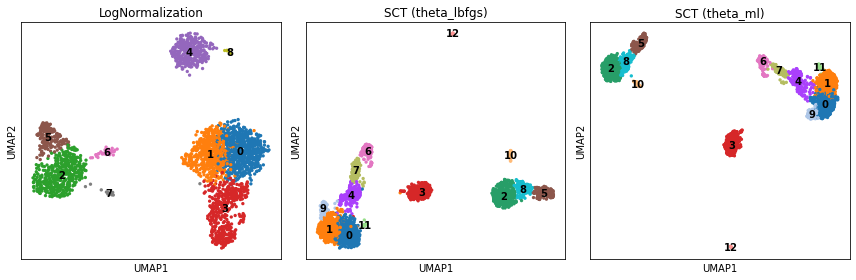

In [8]:
_ = ax1.set_title("LogNormalization")
_ = ax2.set_title("SCT (theta_lbfgs)")
_ = ax3.set_title("SCT (theta_ml)")
fig.tight_layout()
fig